# Finding Donors for CharityML

In this project I'm going to employ several supervised algorithms to accurately model individual's income using data collected from the 1994 U.S. Census. Then I'm going to choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal is to construct a model that accurately predicts whether and individual makes more than $50,000. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

## Exploring the Data

The last column in the dataset,`'income'`, is the target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import seaborn as sn
from sklearn.preprocessing import LabelEncoder

# import supplementary visualization code visuals.py
# import visuals as vs

# display for notebooks
%matplotlib inline

# load the Census dataset
data = pd.read_csv('census.csv')

# display first row
data.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [4]:
# total number of records
n_records = data.shape[0]

# number of records where individual's income is more than $50,000
n_greater_50k = data.query('income == ">50K"').shape[0]

# number of records where individual's income is at most $50,000
n_at_most_50k = data.query('income == "<=50K"').shape[0]

# percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k/n_records)*100

# print results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


The dataset is unbalanced. There're less records where individuals make more than $50,000.

**Feature Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

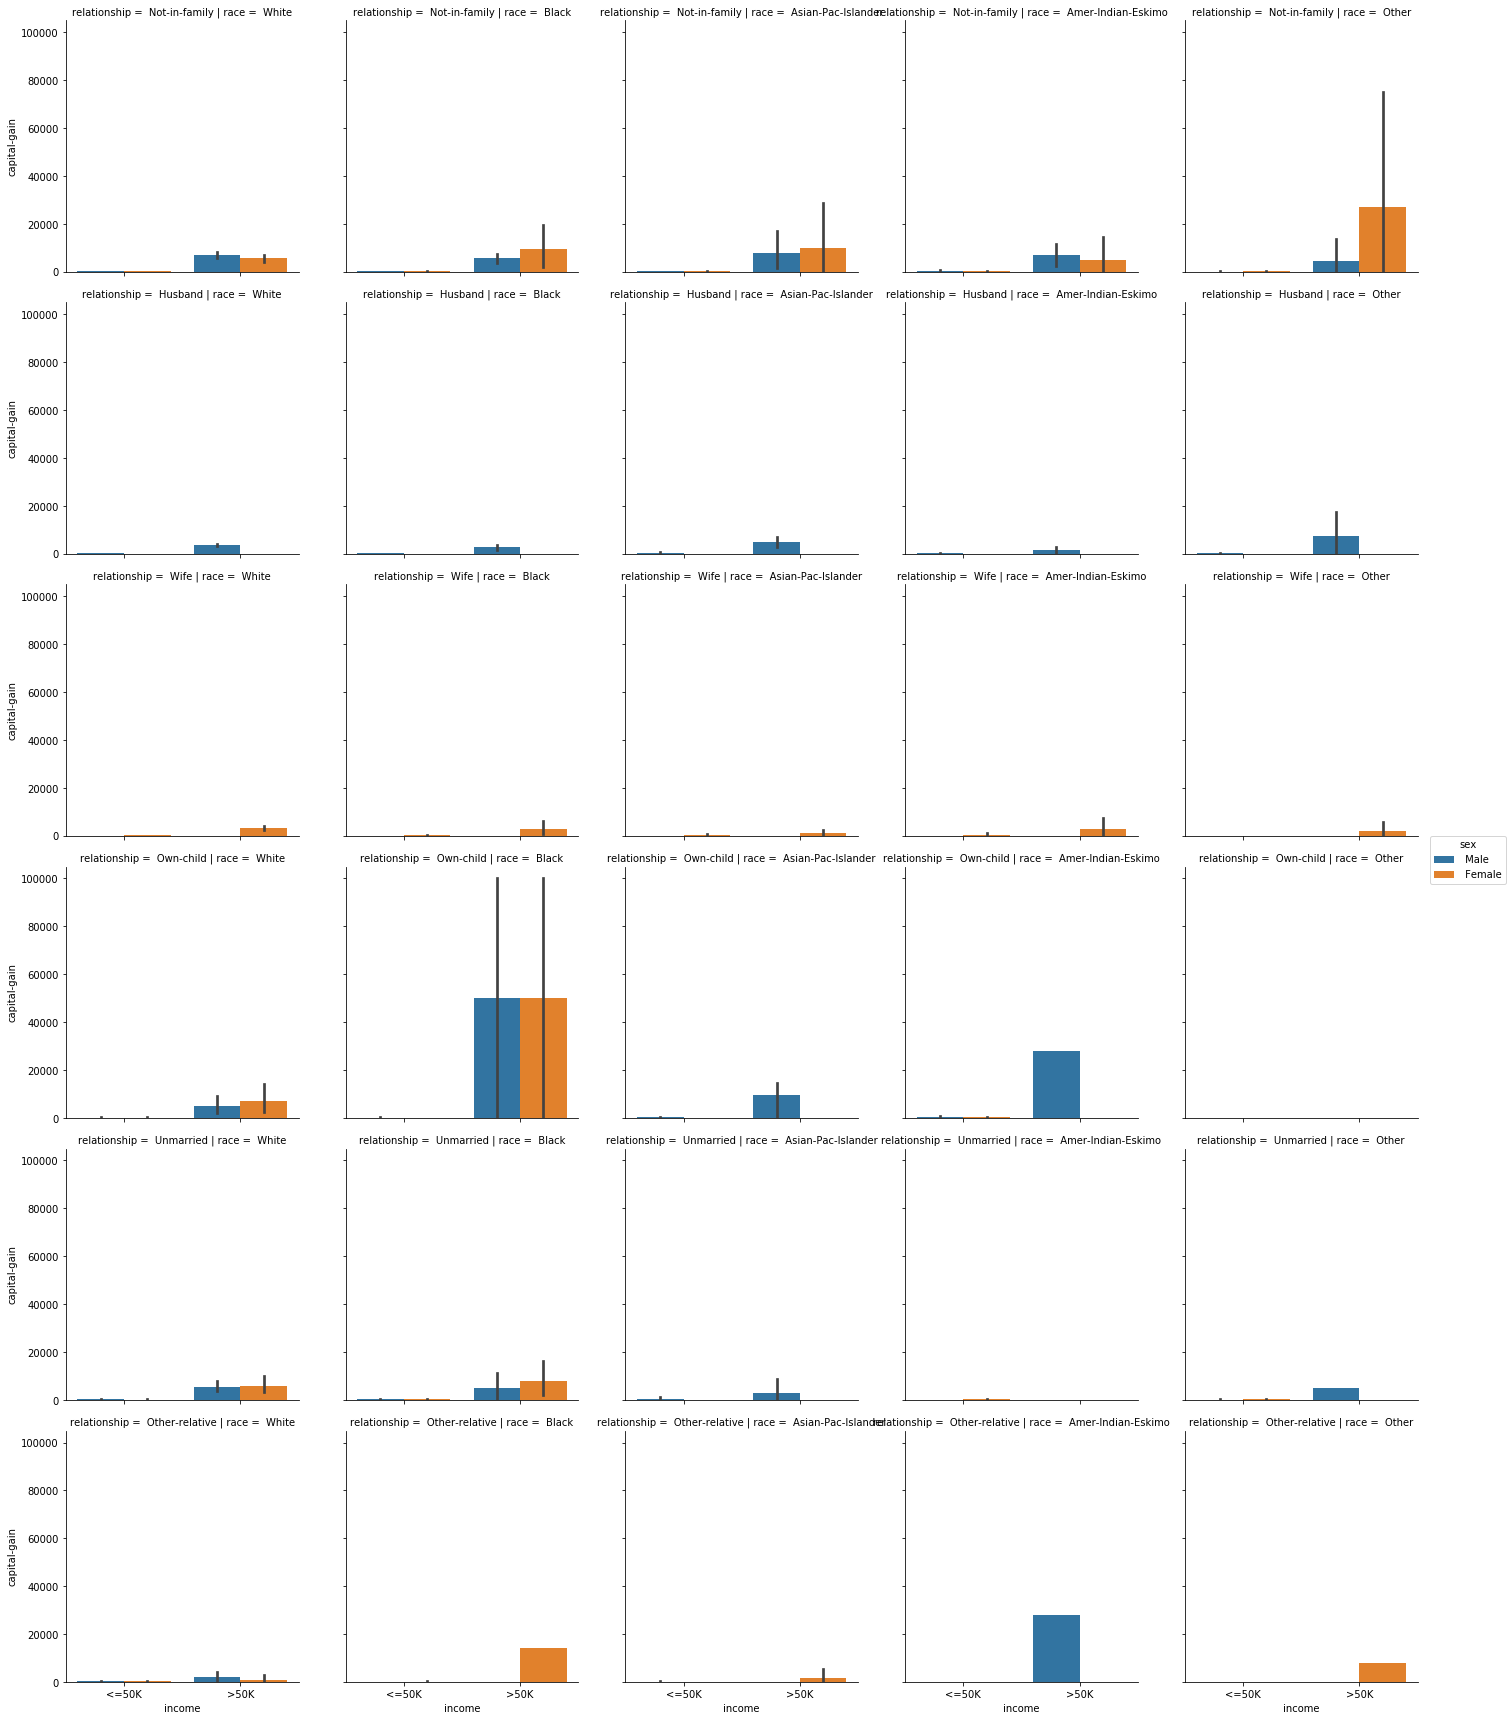

In [5]:
# visualize features of the data
sn.factorplot('income', 'capital-gain', hue='sex', data = data,
              kind='bar', col='race', row='relationship',
              legend=True);